In [22]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import Compose

In [23]:
transform_train = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.RandomAffine(degrees=0.1, translate=(0.25, 0.25), scale=(0.75, 1.25)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
validation_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
validation_loader = DataLoader(validation_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)


In [24]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Define the layers of the model
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Adjust the size here appropriately based on your image input size
        self.fc1 = nn.Linear(32 * 25 * 25, 32)  # Calculate the flattened size correctly
        self.fc2 = nn.Linear(32, 7)  # Assuming 7 classes, adjust if different

    def forward(self, x):
        # Define the forward pass
        x = self.pool(self.relu(self.conv1(x)))  # Convolution, ReLU activation, and Pooling
        x = x.view(-1, 32 * 25 * 25)  # Flatten the output for the Dense layer
        x = self.relu(self.fc1(x))  # First fully connected layer
        x = self.fc2(x)  # Output logits directly
        return x



In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN()  # Define the model
model.to(device)
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [26]:
def train_model(model, train_loader, validation_loader, epochs):
    model.train()
    for epoch in range(epochs):
        start = time.time()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        end = time.time()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Time: {end - start}s')

        validate_model(model, validation_loader)

def validate_model(model, loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Validation Accuracy: {100 * correct / total}%')

train_model(model, train_loader, validation_loader, 50)


Epoch 1, Loss: 1.7485870122909546, Time: 0.7793173789978027s
Validation Accuracy: 42.65569917743831%
Epoch 2, Loss: 1.2146995067596436, Time: 0.4259181022644043s
Validation Accuracy: 50.8813160987074%
Epoch 3, Loss: 1.1639107465744019, Time: 0.41793346405029297s
Validation Accuracy: 63.92479435957697%
Epoch 4, Loss: 0.9554319977760315, Time: 0.43129682540893555s
Validation Accuracy: 71.44535840188014%
Epoch 5, Loss: 0.9654350876808167, Time: 0.4147806167602539s
Validation Accuracy: 74.85311398354877%
Epoch 6, Loss: 0.8739617466926575, Time: 0.41564226150512695s
Validation Accuracy: 77.67332549941246%
Epoch 7, Loss: 0.583928644657135, Time: 0.42338991165161133s
Validation Accuracy: 74.85311398354877%
Epoch 8, Loss: 0.699816107749939, Time: 0.4276885986328125s
Validation Accuracy: 76.49823736780259%
Epoch 9, Loss: 0.5587337613105774, Time: 0.43607664108276367s
Validation Accuracy: 77.2032902467685%
Epoch 10, Loss: 0.5579213500022888, Time: 0.4234788417816162s
Validation Accuracy: 80.4935

In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total = 0
    correct = 0
    total_loss = 0.0

    with torch.no_grad():  # Temporarily set all the requires_grad flag to false
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    average_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f'Test Loss: {average_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%')

# Assuming the model, test_loader and criterion are already defined and initialized
evaluate_model(model, test_loader, criterion)

Test Loss: 0.0755
Test Accuracy: 98.35%


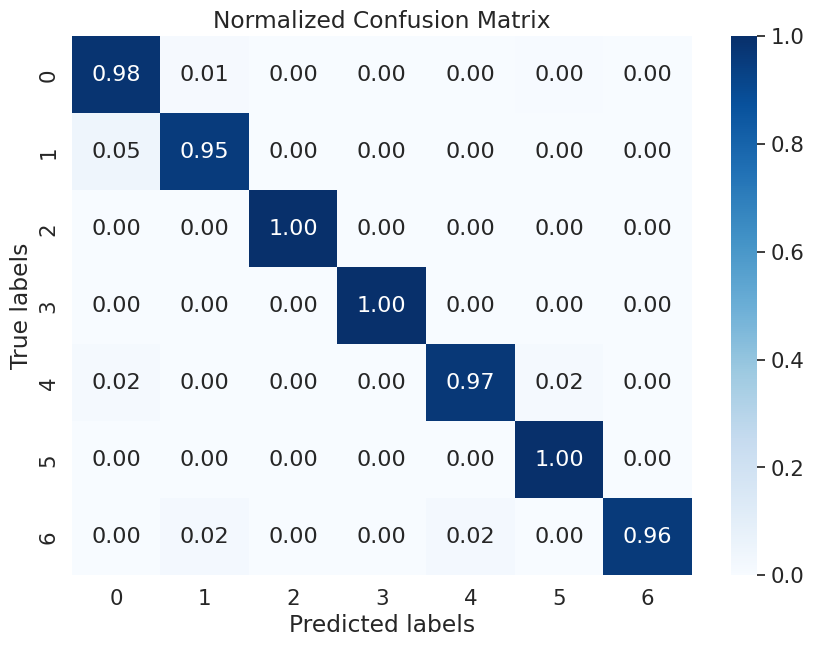

In [28]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def get_predictions_and_labels(model, loader):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)  # Ensure images are on the same device as model
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())  # Move predictions to CPU and convert to numpy
            all_labels.extend(labels.cpu().numpy())  # Move labels to CPU and convert to numpy
    return all_preds, all_labels

# Assuming test_loader is defined and properly set up
predictions, labels = get_predictions_and_labels(model, test_loader)

# Normalizing the confusion matrix by the true (rows) condition
cm = confusion_matrix(labels, predictions, normalize='true')

sns.set(font_scale=1.4)  # for label size
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt=".2f", cmap='Blues')  # font size and format
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Normalized Confusion Matrix')
plt.show()